# AI for Impact - Transforming Digital Family Support in Germany - Data Exploration

## Introduction

Welcome to the Data Exploration Notebook! 👋
 
This notebook is designed to help you get started with exploring the dataset provided for this challenge. We'll walk through the basic structure of the data, but leave plenty of room for you to make your own discoveries and insights.

### What's in this Dataset?

The dataset consists of three main components:
1. **Content Data**: Markdown files scraped from Elternleben.de containing parenting information, advice, and resources
2. **Metadata**: Information about each content page, including titles, descriptions, and categories
3. **Conversation Logs**: Anonymized conversations from a previous chatbot prototype

**Note:** In addition to the content and conversation data, the hackathon also provides a mock database and API for service integration, which we'll explore later in this notebook.

### Challenge Goals

As you work through this notebook, keep in mind the two primary goals of this hackathon:

1. **High-quality Conversational Intelligence and User Engagement**
   - Building empathetic, engaging conversations with personalized responses
   - Maintaining context and understanding user needs
   - Ensuring high-quality, accurate content recommendations

2. **Multi-Touchpoint Service Integration**
   - Creating seamless connections between the chatbot and service ecosystem
   - Intelligent routing between automated responses and expert consultations
   - Implementing direct scheduling capabilities

Keep these goals in mind as we explore the data - your analysis should help identify patterns and insights that will support these objectives.

Let's dive in and start exploring! 📊

## Setup and Dataset Overview

Let's start by importing the necessary libraries and loading the datasets.

In [1]:
# We will use pandas for data manipulation and matplotlib/seaborn for visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import glob

%matplotlib inline

In [2]:
# Load metadata and conversation data
metadata = pd.read_csv('data/metadata.csv')
conversations = pd.read_csv('data/processed_conversations.csv')

## 1. Metadata exploration

First, let's explore the `metadata.csv` file, which contains information about all the content pages from Elternleben.de. This will give us an understanding of what topics are covered on the website and how the content is organized.


In [3]:
# Display basic information about the datasets
print(f"Content metadata: {len(metadata)} articles")
# Preview metadata
display(metadata.head())

Content metadata: 750 articles


,url,filepath,filename,title,description,author,category,crawled_at
0,https://www.elternleben.de/haeufige-fragen/tro...,content/elternleben/haeufige-fragen/trotz-wut.md,trotz-wut.md,Trotz und Wut – Häufige Elternfragen,Die Autonomiephase eines Kindes ist sehr wicht...,NaN,['haeufige-fragen'],2025-03-05T19:44:00.824427
1,https://www.elternleben.de/baby/entwicklung-ba...,content/elternleben/baby/entwicklung-baby/wie-...,wie-du-dein-baby-richtig-traegst.md,Wie du dein Baby richtig trägst - Tipps zur Tr...,"Erfahre, wie du dein Baby im Tragetuch oder in...",Esther Howoldt,"['baby', 'entwicklung-baby']",2025-03-05T19:44:02.115949
2,https://www.elternleben.de/baby/babyschlaf/wie...,content/elternleben/baby/babyschlaf/wie-viel-s...,wie-viel-schlaf-braucht-ein-baby.md,Wie viel Schlaf braucht ein Baby?,Wieviel Schlaf braucht ein Baby in den verschi...,Melanie Schüer,"['baby', 'babyschlaf']",2025-03-05T19:44:04.160184
3,https://www.elternleben.de/erziehung-und-foerd...,content/elternleben/erziehung-und-foerderung/k...,kind-ist-schuechtern.md,Warum ist mein Kind so schüchtern?,Mein Kind ist schüchtern. Es möchte nichts Neu...,Melanie Schüer,['erziehung-und-foerderung'],2025-03-05T19:44:05.574111
4,https://www.elternleben.de/baby/gesundes-baby/...,content/elternleben/baby/gesundes-baby/baby-ha...,baby-hat-schnupfen.md,Baby hat Schnupfen und verstopfte Nase – Was tun?,"Wenn das Baby Schnupfen hat, kann es auch für ...",Dr. Nikola Klün,"['baby', 'gesundes-baby']",2025-03-05T19:44:05.927799


The metadata includes information such as:
- URLs and file paths of content
- Titles and descriptions
- Categories and authors
- Timestamps when content was crawled

Let's analyze the data to understand what types of content are available, how they're organized, and which topics are most common.


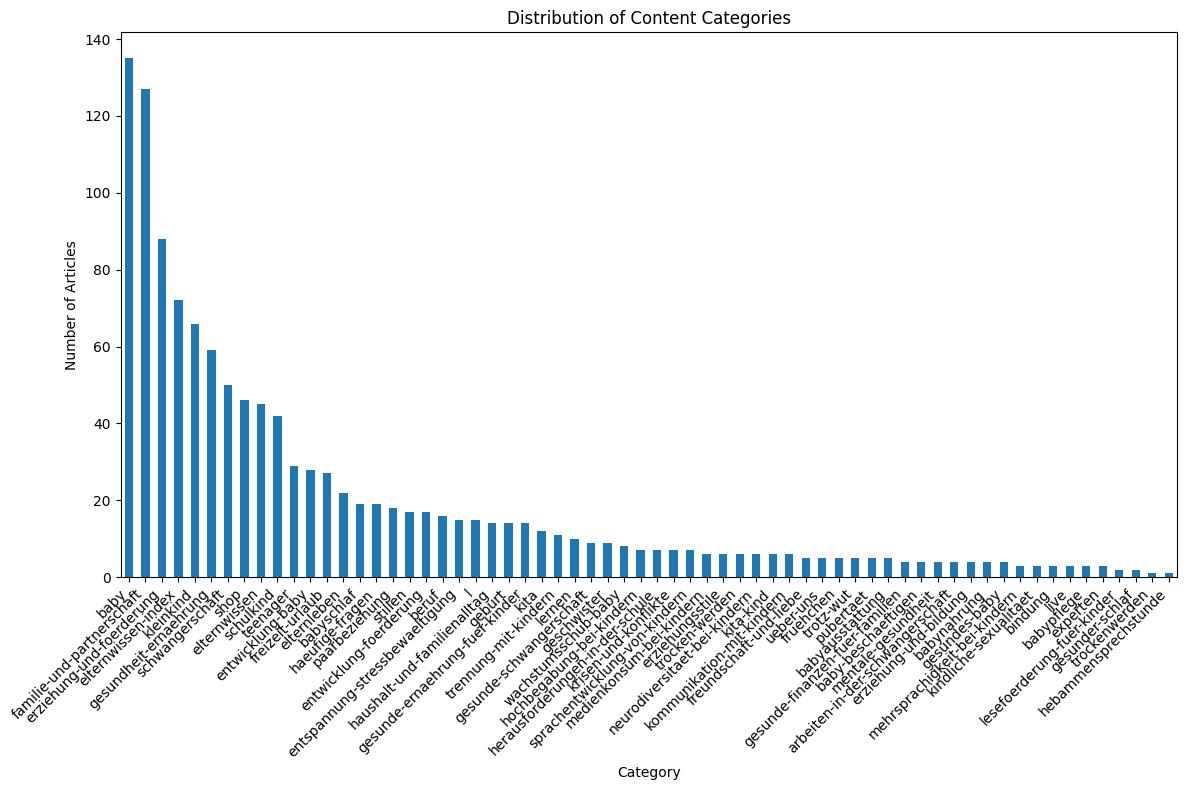

In [4]:
# Look at the distribution of content categories
# Extract categories from the array and count them
all_categories = []
for cat_list in metadata['category']:
    # Convert string representation of list to actual list
    if isinstance(cat_list, str):
        # Remove brackets and quotes, then split by comma
        categories = cat_list.strip('[]').replace("'", "").split(', ')
        all_categories.extend(categories)

# Count occurrences of each category
category_counts = pd.Series(all_categories).value_counts()

# Visualize the category distribution
plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar')
plt.title('Distribution of Content Categories')
plt.ylabel('Number of Articles')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

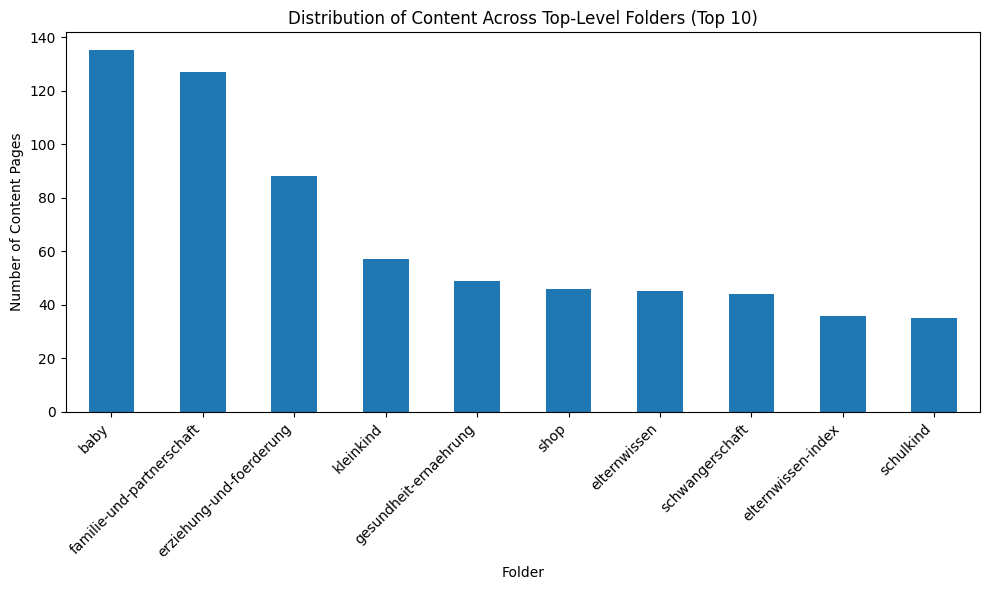

In [5]:
# Examine the hierarchy structure based on filepaths
def get_top_level_folder(filepath):
    parts = filepath.split('/')
    # General top folders are called "content" and "elternleben": content/elternleben/...
    # That's why always return the third element
    return parts[2] if len(parts) > 0 else None

metadata['top_folder'] = metadata['filepath'].apply(get_top_level_folder)
top_folders = metadata['top_folder'].value_counts()

# Visualize the distribution
plt.figure(figsize=(10, 6))

# Top 15 folders
top_folders.head(10).plot(kind='bar')
plt.title('Distribution of Content Across Top-Level Folders (Top 10)')
plt.ylabel('Number of Content Pages')
plt.xlabel('Folder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Exploration Ideas:
- How does the content distribution vary across different categories?
- Are there patterns in how the content is organized?
- What are the most common topics covered in the content?
- How might the content hierarchy influence chatbot recommendations?

## 2. Content File Exploration

The `content` files contain the actual parenting information and advice that the chatbot can recommend to users. These markdown files represent the knowledge base that powers the chatbot's responses.

Understanding the content structure is essential for:
- Developing effective content recommendation algorithms
- Extracting relevant snippets for responses
- Identifying topics and subtopics within the content
- Mapping user queries to appropriate content

Let's examine a sample of these files to understand their structure and format:

In [6]:
# Function to read markdown files
def read_markdown_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read()

# Get a list of a few sample markdown files
content_files = glob.glob("data/content/**/*.md", recursive=True)
print(f"Total content files found: {len(content_files)}")

# Let's look at the structure of a sample file (feel free to change the index)
if content_files:
    sample_file = content_files[42]
    print(f"\nSample file: {sample_file}")
    content = read_markdown_file(sample_file)

    # Check for metadata section
    metadata_match = re.search(r'---\n(.*?)\n---', content, re.DOTALL)
    if metadata_match:
        print("\nMetadata section found")
    
    # Display the markdown file
    print("\nFile content:")
    print(content)

Total content files found: 750

Sample file: data/content/elternleben/schwangerschaft/geburt/hannah-loewe-hormone-nach-der-geburt-gehirn-im-ausnahmezustand.md

Metadata section found

File content:
---
author: ''
category:
- schwangerschaft
- geburt
crawled_at: '2025-03-05T20:02:24.569297'
description: 'Nach der Geburt spielen die Hormone einer Mutter verrückt. Du hast das
  Gefühl, den Alltag nicht im Griff zu haben? Hannah Löwe: Die erste Zeit mit dem
  Baby'
filename: hannah-loewe-hormone-nach-der-geburt-gehirn-im-ausnahmezustand.md
filepath: elternleben/schwangerschaft/geburt/hannah-loewe-hormone-nach-der-geburt-gehirn-im-ausnahmezustand.md
title: 'Hannah Löwe: Hormone nach der Geburt - Gehirn im Ausnahmezustand'
url: https://www.elternleben.de/schwangerschaft/geburt/hannah-loewe-hormone-nach-der-geburt-gehirn-im-ausnahmezustand/
---

#  Hormone nach der Geburt - Gehirn im Ausnahmezustand

Es ist schon ein tolles Gefühl sein Baby in den Armen zu halten und sich
einfach nur freuen z

### Exploration Ideas:
- What are the common themes or topics across the content files?
- How is the content structured (headings, paragraphs, lists, etc.)?
- How could you extract key information from these content files to provide concise answers?
- What preprocessing steps might be helpful to organize this content for retrieval?

## 3. Conversation Data Exploration

Understanding the conversation data is critical for building an effective chatbot. These logs from a previous prototype provide insights into how parents interact with the system, what questions they ask, and how the previous chatbot responded.

The conversation data helps us understand:
- Common user queries and concerns
- Patterns in conversation flow
- When human escalation was needed
- What types of responses were most effective

Let's explore this data to gain insights for our new chatbot design:

In [7]:
print(f"Conversation logs: {len(conversations)} messages in {conversations['conversation_id'].nunique()} conversations")
display(conversations.head())

Conversation logs: 216 messages in 128 conversations


,conversation_id,user_message,chatbot_response,needs_escalation,recommended_approach,response_link_1,response_link_2,response_link_3,response_link_4,response_link_5,conversation_start,request_timestamp,response_timestamp
0,21,Mein Kind hat Angst vorm Kindergarten,"Es ist ganz normal, dass Kinder Angst vor dem ...",False,"Information Support, Emotional Support",https://www.elternleben.de/haeufige-fragen/kit...,https://www.elternleben.de/elternsprechstunde/,https://www.elternleben.de/ueber-stell-uns-dei...,NaN,NaN,2024-11-08T13:20:33.399Z,"Fri Nov 8, 2024 1:10 PM","Fri Nov 8, 2024 1:11 PM"
1,22,Ausraster mir hauen und Gegenstände werfen,"Es ist ganz normal, dass Kinder manchmal Wutan...",False,"Information Support, Emotional Support",https://www.elternleben.de/elternwissen/kleink...,https://www.elternleben.de/elternsprechstunde/,NaN,NaN,NaN,2024-11-08T15:50:32.278Z,"Fri Nov 8, 2024 3:41 PM","Fri Nov 8, 2024 3:41 PM"
2,22,Das passiert meist in der Schule,"Es kann sehr herausfordernd sein, wenn ein Kin...",False,"Information Support, Emotional Support",https://www.elternleben.de/haeufige-fragen/tro...,https://www.elternleben.de/elternsprechstunde/,NaN,NaN,NaN,2024-11-08T15:50:32.278Z,"Fri Nov 8, 2024 3:42 PM","Fri Nov 8, 2024 3:42 PM"
3,23,"Mein Kind, 6Jahre hat Wutanfälle bei denen er ...",Das klingt nach einer herausfordernden Situati...,False,"Information Support, Emotional Support",NaN,NaN,NaN,NaN,NaN,2024-11-08T20:00:17.879Z,"Fri Nov 8, 2024 7:50 PM","Fri Nov 8, 2024 7:50 PM"
4,23,Die Wutanfällle kommen schon bei Kleinigkeiten...,"Es ist verständlich, dass du dir Sorgen machst...",False,"Information Support, Emotional Support",https://www.elternleben.de/elternwissen/kita-k...,https://www.elternleben.de/elternsprechstunde/,https://www.elternleben.de/ueber-stell-uns-dei...,NaN,NaN,2024-11-08T20:00:17.879Z,"Fri Nov 8, 2024 7:51 PM","Fri Nov 8, 2024 7:51 PM"


Let's explore some basic patterns in the conversations:

In [8]:
conversations['user_message_length'] = conversations['user_message'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
conversations['bot_response_length'] = conversations['chatbot_response'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Basic statistics on message lengths
print("User message length statistics:")
print(conversations['user_message_length'].describe())

print("\nChatbot response length statistics:")
print(conversations['bot_response_length'].describe())

User message length statistics:
count    216.000000
mean      10.194444
std       16.695053
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max      210.000000
Name: user_message_length, dtype: float64

Chatbot response length statistics:
count    216.000000
mean     146.171296
std       70.119123
min       16.000000
25%       78.750000
50%      167.500000
75%      200.250000
max      283.000000
Name: bot_response_length, dtype: float64


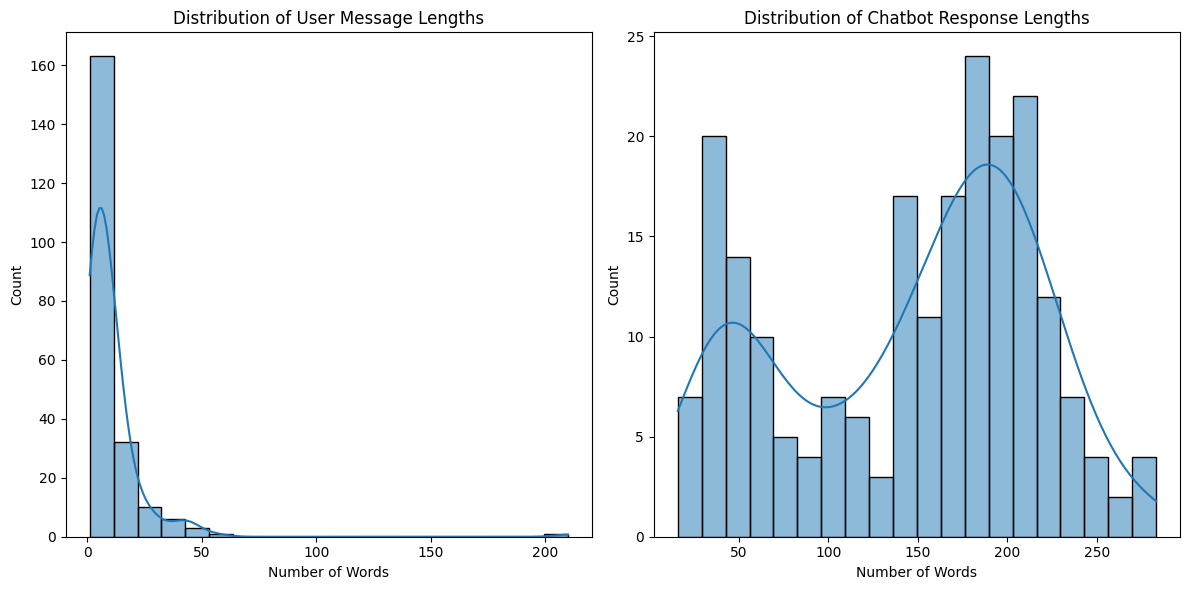

In [9]:
# Plot the distribution of message lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(conversations['user_message_length'], bins=20, kde=True)
plt.title('Distribution of User Message Lengths')
plt.xlabel('Number of Words')

plt.subplot(1, 2, 2)
sns.histplot(conversations['bot_response_length'], bins=20, kde=True)
plt.title('Distribution of Chatbot Response Lengths')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()

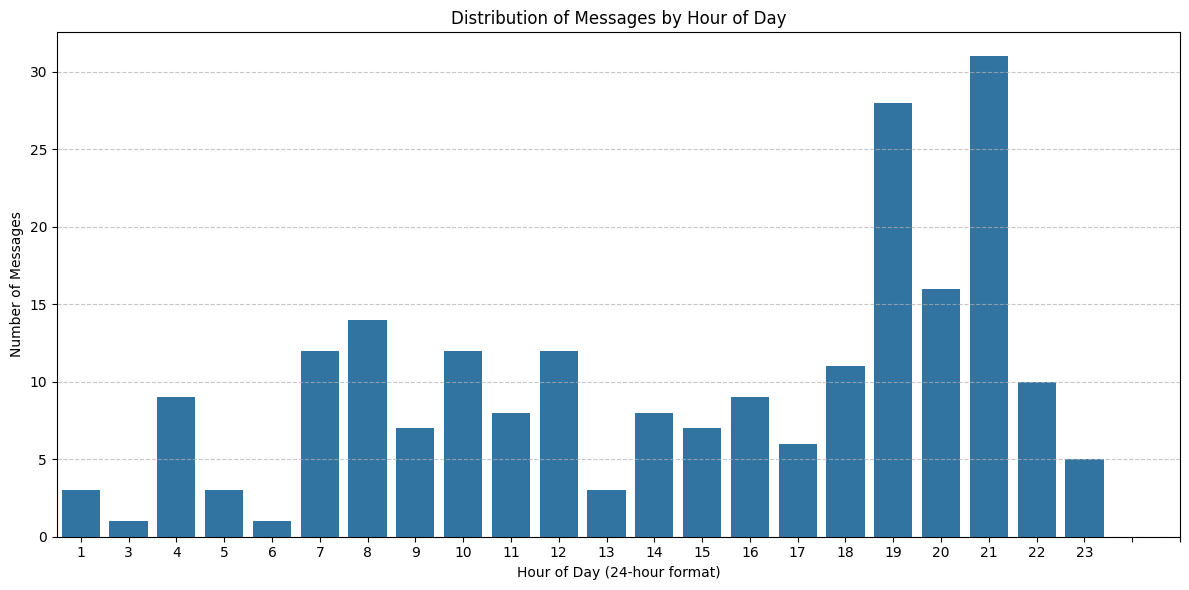

Busiest hours of the day:
21:00 - 21:59: 14.4% of messages
19:00 - 19:59: 13.0% of messages
20:00 - 20:59: 7.4% of messages


In [10]:
# Extract hour from the timestamp for time-of-day analysis
conversations['hour'] = pd.to_datetime(conversations['request_timestamp'], format='%a %b %d, %Y %I:%M %p').dt.hour

# Count messages per hour
messages_per_hour = conversations['hour'].value_counts().sort_index()

# Plot messages per hour
plt.figure(figsize=(12, 6))
sns.barplot(x=messages_per_hour.index, y=messages_per_hour.values)
plt.title('Distribution of Messages by Hour of Day')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Messages')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate percentage of messages by hour
percentage_per_hour = (messages_per_hour / messages_per_hour.sum() * 100).round(1)

# Print the busiest hours
print("Busiest hours of the day:")
for hour, percentage in percentage_per_hour.nlargest(3).items():
    print(f"{hour:02d}:00 - {hour:02d}:59: {percentage}% of messages")


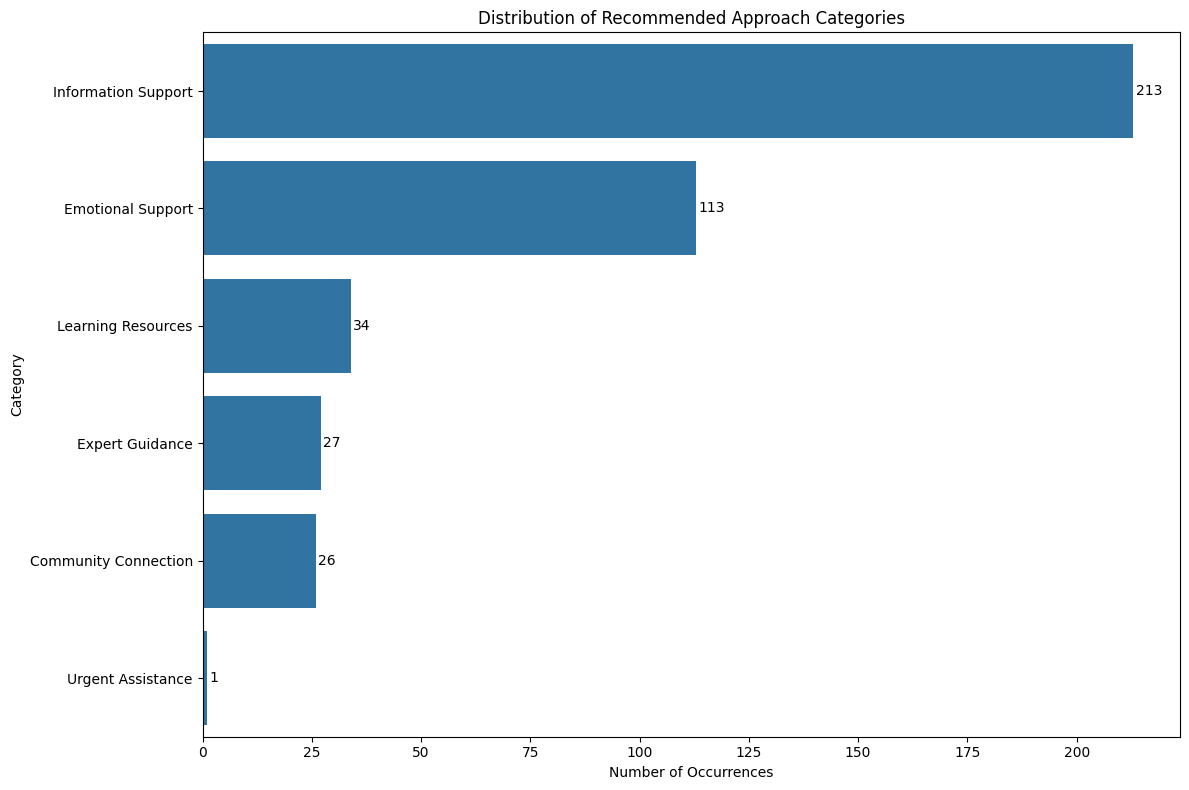

Top recommended approach categories:
Information Support: 213 occurrences (98.6% of conversations)
Emotional Support: 113 occurrences (52.3% of conversations)
Learning Resources: 34 occurrences (15.7% of conversations)
Expert Guidance: 27 occurrences (12.5% of conversations)
Community Connection: 26 occurrences (12.0% of conversations)


In [11]:
# Extract and analyze the recommended approach categories
# Split the categories and explode to get one row per category
categories_df = conversations['recommended_approach'].str.split(',').explode().str.strip()

# Count the occurrences of each category
category_counts = categories_df.value_counts()

# Plot the distribution of categories
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=category_counts.values, y=category_counts.index)

# Add count labels to the bars
for i, count in enumerate(category_counts.values):
    ax.text(count + 0.5, i, str(count), va='center')

plt.title('Distribution of Recommended Approach Categories')
plt.xlabel('Number of Occurrences')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Print the top categories
print("Top recommended approach categories:")
for category, count in category_counts.head(5).items():
    percentage = (count / len(conversations)) * 100
    print(f"{category}: {count} occurrences ({percentage:.1f}% of conversations)")


### Exploration Ideas:
- What are the common patterns in user queries?
- What types of responses lead to successful interactions vs. those requiring escalation?
- Is there a correlation between message length and the need for escalation?
- How do different conversation categories (information-seeking, problem-solving, etc.) relate to recommended approaches?
- What language patterns indicate a need for personalized responses versus general information?

## 4. Integration Points and Service Opportunities

A key aspect of this chatbot is identifying when users need services beyond just information. The chatbot should be able to recognize when to offer webinar registrations or expert consultations.

This section explores potential integration points between conversations and services:
- Identifying service-related keywords in user messages
- Recognizing patterns that indicate service needs
- Understanding when to transition from information to service booking

Let's analyze the conversations to find potential service opportunities:Additionally, let's examine the content recommendation patterns in the existing chatbot responses:

In [12]:
# Look for service-related keywords in user messages
service_keywords = ['termin', 'beratung', 'webinar', 'buchung', 'anmeldung', 'expert', 'konsultation']

def contains_service_keywords(text):
    if pd.isna(text):
        return False
    text = text.lower()
    return any(keyword in text for keyword in service_keywords)

conversations['service_related'] = conversations['user_message'].apply(contains_service_keywords)

service_related_count = conversations['service_related'].sum()
print(f"Number of service-related messages: {service_related_count} ({service_related_count/len(conversations)*100:.1f}%)")

# Look at a few examples of service-related queries
if service_related_count > 0:
    print("\nSample service-related queries:")
    service_samples = conversations[conversations['service_related']].head(5)
    for i, row in service_samples.iterrows():
        print(f"Query: {row['user_message']}")
        print(f"Response: {row['chatbot_response']}")
        print("---")

Number of service-related messages: 2 (0.9%)

Sample service-related queries:
Query: Ja bitte um Beratung
Response: Natürlich! Für eine persönliche Beratung kannst du unsere
E-Mail-Beratung nutzen. Dort kannst du deine spezifischen Fragen stellen und erhältst innerhalb von 36–48 Stunden eine Antwort von unseren Experten. 😊
---
Query: Persönliche Beratung
Response: Für eine persönliche Beratung zum Thema Babyschlaf kann ich dir unsere Hebammenberatung empfehlen. Dort erhältst du Unterstützung von erfahrenen Hebammen, die dir bei deinen individuellen Fragen helfen können. Hier ist der Link zur Hebammenberatung:
Hebammensprechstunde. 😊 Falls du noch weitere Fragen hast oder eine andere Art von Unterstützung benötigst, lass es mich gerne wissen!
---


### Exploration Ideas for Participants:
- How could the chatbot better identify when a user needs to be connected to a service?
- What information needs to be collected from the user before routing to a service?
- What conversational strategies could make the transition to service booking feel natural?
- How might you design the conversation flow to gather necessary booking information?

## 5. Content Recommendation Analysis

Content recommendation is a crucial capability of the chatbot. Parents come to [Elternleben.de](https://www.elternleben.de/) seeking information, and the chatbot should efficiently connect them with the most relevant resources.

In this section, we'll examine:
- How often the previous chatbot provided content links
- Which content was most frequently recommended
- Patterns between user queries and recommended content
- Potential areas for improving content recommendations

Let's analyze the existing recommendation patterns:

In [13]:
# Analyze content links in responses
# Check if any of the response_links columns (1-5) contain links
conversations['has_links'] = (
    conversations['response_link_1'].notna() & (conversations['response_link_1'] != '') |
    conversations['response_link_2'].notna() & (conversations['response_link_2'] != '') |
    conversations['response_link_3'].notna() & (conversations['response_link_3'] != '') |
    conversations['response_link_4'].notna() & (conversations['response_link_4'] != '') |
    conversations['response_link_5'].notna() & (conversations['response_link_5'] != '')
)

link_count = conversations['has_links'].sum()
print(f"Number of responses with content links: {link_count} ({link_count/len(conversations)*100:.1f}%)")

# Let's look at the distribution of links
if link_count > 0:
    # Extract and count all links
    all_links = []
    # Collect links from all response_link columns (1-5)
    for idx, row in conversations.iterrows():
        for col in ['response_link_1', 'response_link_2', 'response_link_3', 'response_link_4', 'response_link_5']:
            links = row.get(col)
            if pd.notna(links) and links:
                all_links.append(links)
    
    link_counter = Counter(all_links)
    
    print("\nTop 10 most recommended content links:")
    for link, count in link_counter.most_common(10):
        print(f"{link}: {count} times")
    
    # Match links with metadata to see what content is being recommended
    if not metadata.empty:
        top_links = [link for link, _ in link_counter.most_common(10)]
        recommended_content = metadata[metadata['url'].isin(top_links)]
        
        if not recommended_content.empty:
            print("\nDetails of most recommended content:")
            for i, row in recommended_content.iterrows():
                print(f"Title: {row['title']}")
                print(f"URL: {row['url']}")
                print(f"Category: {row['category']}")
                print("---")

Number of responses with content links: 171 (79.2%)

Top 10 most recommended content links:
https://www.elternleben.de/ueber-stell-uns-deine-frage/: 140 times
https://www.elternleben.de/elternsprechstunde/: 59 times
https://www.elternleben.de/hebammensprechstunde/: 21 times
https://www.elternleben.de/shop/video-seminar-babyschlaf/: 16 times
https://www.elternleben.de/haeufige-fragen/kita/wie-sieht-ein-typischer-tagesablauf-in-der-kita-aus/: 10 times
https://www.elternleben.de/haeufige-fragen/kita/mein-kind-ist-aggressiv-und-schlaegt-andere-kinder-in-der-kita-muss-ich-etwas-tun/: 7 times
https://www.elternleben.de/baby/babyschlaf/baby-wacht-staendig-auf/: 6 times
https://www.elternleben.de/elternwissen/kleinkind/entwicklung-und-foerderung/einschlaf-tipps-fuer-kinder-von-zwei-bis-fuenf-jahren/: 5 times
https://www.elternleben.de/elternwissen/kleinkind/erziehung-und-bildung/wutanfaelle-treten-beissen-kratzen-was-tun-wenn-mein-kind-aggressiv-wird/: 4 times
https://www.elternleben.de/haeufi

### Exploration Ideas for Participants:
- What content is most frequently recommended?
- Is there a correlation between certain user queries and specific content recommendations?
- How could the content recommendation system be improved?
- Could semantic understanding of both queries and content improve recommendations?
- How might you personalize recommendations based on conversation context?

## 6. Mock API and Service Integration

A key part of this challenge is integrating the chatbot with services like webinars and expert consultations. This integration creates a complete user journey - from asking questions to booking relevant services.

The repository provides a mock API that simulates:
- Webinar management (similar to [Zoom API](https://developers.zoom.us/docs/api/meetings/#tag/webinars))
- Expert consultation booking (similar to [SimplyBook API](https://simplybook.me/de/api/developer-api/tab/doc_api?_gl=1*bmg1tv*_up*MQ..*_ga*NjI3NzI5NjQyLjE3NDIyMjA4MzA.*_ga_DF4Z49WJND*MTc0MjIyMDgyOS4xLjAuMTc0MjIyMDgyOS4wLjAuMA..&gclid=CjwKCAiA5pq-BhBuEiwAvkzVZfssJJvthaPwsh2Alzu-rNCaWfaqxhgL_9kYdI34s-XLlpL9qk9cRxoCv1UQAvD_BwE))

To use the mock API service, please refer to the Mock API section in [**README**](README.md).

### Exploring Database Structure

The hackathon includes a SQLite database with sample data. Let's examine its structure:

In [14]:
import sqlite3
import pandas as pd

# Connect to the SQLite database (if available)
try:
    conn = sqlite3.connect('mock_api/mock_api.db')
    
    # Get list of tables
    table_query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql_query(table_query, conn)
    
    print("Database tables found:")
    for table in tables['name']:
        print(f"- {table}")
    
    # Sample data from each table
    for table in tables['name']:
        print(f"\nSample data from {table}:")
        sample_data = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 3", conn)
        display(sample_data)
    
    conn.close()
except Exception as e:
    print(f"Error connecting to database: {str(e)}")
    print("Note: You'll need to run 'python create_database.py' to generate the mock database first")

Database tables found:
- webinars
- webinar_registrants
- experts
- appointments

Sample data from webinars:


,uuid,host_id,topic,start_time,duration,agenda,join_url,status
0,0cb0ca9a-9a0c-4389-8dd0-8c487aec3c52,f2fac462-2edd-4a99-b07c-089567d438b3,Elternzeit und Elterngeld: Was Sie wissen müssen,2025-03-18T02:25:07,120,In diesem Webinar besprechen wir die gesetzlic...,https://mock-zoom.elternleben.de/webinare/elte...,completed
1,11cb3056-84f0-4f46-9f60-3e73073b7139,35e8cd3f-0af5-4465-a325-e3cc85652e87,Frühkindliche Entwicklung: Die ersten 3 Jahre,2025-03-21T00:25:07,60,Dieses Webinar behandelt die wichtigsten motor...,https://mock-zoom.elternleben.de/webinare/frue...,completed
2,4b6d9911-2134-4adb-a31f-a665e8c65454,c50399be-94fd-43c1-9865-3f7f1fe2aceb,Gesunde Ernährung für Kleinkinder,2025-03-24T07:25:07,90,Unser Ernährungswebinar deckt den Nährstoffbed...,https://mock-zoom.elternleben.de/webinare/gesu...,active



Sample data from webinar_registrants:


,uuid,webinar_id,name,email
0,3b6b156c-8b74-4d9d-b6f0-7c1c09b3eda3,0cb0ca9a-9a0c-4389-8dd0-8c487aec3c52,Sophia Koch,sophia.koch@mail.com
1,5dc34631-7ff6-4de5-8c5a-8ec522748837,0cb0ca9a-9a0c-4389-8dd0-8c487aec3c52,Sabine Becker,sabine.becker@gx.de
2,ef31127d-2de3-4836-bbeb-546cc66b7ee0,0cb0ca9a-9a0c-4389-8dd0-8c487aec3c52,Klaus Wagner,klaus.wagner@gx.de



Sample data from experts:


,uuid,name,specialty,is_available,zoom_host_id
0,ba5e1138-650d-43c2-801d-706075616c00,Dr. Anna Weber,Kinderärztin,1,host_weber
1,aa0fc503-d182-446d-aeae-8a2bb2738329,Thomas Schröder,Entwicklungspsychologe,1,host_schroeder
2,00cf4d7d-2266-4885-8b9d-2c43cdae33c6,Marion Fischer,Hebamme,1,host_fischer



Sample data from appointments:


,uuid,expert_id,service,datetime,client_name,client_email,client_phone,is_booked,status
0,c3251b8a-db88-40c9-96f5-36da68d95c9f,c50399be-94fd-43c1-9865-3f7f1fe2aceb,folgeberatung,2025-04-02T12:00:00,None,None,None,0,None
1,ab1ec65d-bf69-4fde-9b5a-00cbb2064158,a015becf-b21a-4c06-a7c6-17fd15a35b93,ernaehrungsberatung,2025-03-18T16:00:00,None,None,None,0,None
2,b08c1c36-b74b-4cf2-94bc-086bf579db3b,00cf4d7d-2266-4885-8b9d-2c43cdae33c6,ernaehrungsberatung,2025-03-31T09:00:00,None,None,None,0,None


Let's come back to the APIs to understand their structure and how to incorporate them into your chatbot solution. 

Additional automatically generated documentation is available under:
   - Interactive Swagger UI: http://127.0.0.1:8000/docs
   - ReDoc interface: http://127.0.0.1:8000/redoc

In [15]:
import requests
import json

# API base URL - when running locally
BASE_URL = "http://127.0.0.1:8000"

# Test if the API is running
try:
    response = requests.get(f"{BASE_URL}/docs")
    api_available = response.status_code == 200
    print(f"API Status: {'Available' if api_available else 'Not Available'}")
except:
    api_available = False
    print("API Status: Not Available")
    print("Note: You'll need to run the mock API server using 'uvicorn mock_api:app'. Please refer to the README for more details.")


API Status: Available


### Exploring Available Webinars

Let's look at the available webinars in the system:

In [16]:
# Only run if API is available
if api_available:
    try:
        # Get webinars for a sample user (host id 1)
        response = requests.get(f"{BASE_URL}/webinars")
        webinars = response.json()
        
        print(f"Number of webinars available: {len(webinars)}")
        
        # Display a sample webinar
        if webinars:
            print("\nSample webinar details:")
            sample_webinar = webinars[0]
            for key, value in sample_webinar.items():
                print(f"{key}: {value}")
        
    except Exception as e:
        print(f"Error accessing webinar API: {str(e)}")

Number of webinars available: 10

Sample webinar details:
uuid: e645a6da-463f-4f37-b4b2-04ce6614ea1e
host_id: f2fac462-2edd-4a99-b07c-089567d438b3
topic: Elternzeit und Elterngeld: Was Sie wissen müssen
type: 5
start_time: 2025-03-18T02:25:07
duration: 120
timezone: UTC
created_at: 2025-01-01T00:00:00Z
agenda: In diesem Webinar besprechen wir die gesetzlichen Grundlagen der Elternzeit, erklären die Berechnung des Elterngeldes, führen durch das Antragsverfahren und wichtige Fristen, diskutieren Möglichkeiten zur Teilzeitarbeit während der Elternzeit und geben Tipps, wie Sie häufige Fehler vermeiden können.
join_url: https://mock-zoom.elternleben.de/webinare/elternzeit-und-elterngeld


### Exploring Available Expert Consultations

Now let's check the expert consultation services:

In [17]:
# Only run if API is available
if api_available:
    try:
        # Get available experts
        response = requests.get(f"{BASE_URL}/experts/available")
        experts = response.json()
        
        print(f"Number of experts available: {len(experts)}")
        
        # Display sample experts
        if experts:
            print("\nSample expert details:")
            for expert in experts[:3]:  # Show first 3 experts
                print(f"UUID: {expert.get('uuid')}")
                print(f"Name: {expert.get('name')}")
                print("---")
        
        # Get available slots for a sample expert
        if experts:
            expert = experts[0]
            expert_id = expert.get('uuid')
            expert_name = expert.get('name')
            response = requests.get(f"{BASE_URL}/experts/{expert_id}/available-slots")
            slots = response.json()
            
            print(f"\nAvailable slots for Expert {expert_name}:")
            for i, slot in enumerate(slots[:5]):  # Show first 5 slots
                print(f"Slot {i+1}: {slot}")
    except Exception as e:
        print(f"Error accessing expert consultation API: {str(e)}")

Number of experts available: 8

Sample expert details:
UUID: ba5e1138-650d-43c2-801d-706075616c00
Name: Dr. Anna Weber
---
UUID: aa0fc503-d182-446d-aeae-8a2bb2738329
Name: Thomas Schröder
---
UUID: 00cf4d7d-2266-4885-8b9d-2c43cdae33c6
Name: Marion Fischer
---

Available slots for Expert Dr. Anna Weber:
Slot 1: {'start_datetime': '2025-03-06T10:00:00Z', 'end_datetime': '2025-03-06T10:30:00Z'}
Slot 2: {'start_datetime': '2025-03-06T12:00:00Z', 'end_datetime': '2025-03-06T12:30:00Z'}
Slot 3: {'start_datetime': '2025-03-06T14:00:00Z', 'end_datetime': '2025-03-06T14:30:00Z'}


### Testing API Integration

Let's test the basic flow of booking an appointment:

In [18]:
# Only run if API is available
if api_available:
    try:
        # Example: Book a consultation (simulate, don't actually submit)

        create_sample_appointment = {
            "client_name": "Test User",
            "client_email": "test@example.com",
            "client_phone": "+49123456789",
            "service": "sprachentwicklung",
            "expert_id": "expert_456",
        }

        print("Sample booking payload:")
        print(json.dumps(create_sample_appointment, indent=2))
        
        # The actual booking would be done with:
        # response = requests.post(f"{BASE_URL}/bookings/new", json=create_sample_appointment)
        # print(response.json())
    except Exception as e:
        print(f"Error preparing sample booking: {str(e)}")

Sample booking payload:
{
  "client_name": "Test User",
  "client_email": "test@example.com",
  "client_phone": "+49123456789",
  "service": "sprachentwicklung",
  "expert_id": "expert_456"
}


## 7. Challenge Questions

These questions are designed to guide your deeper analysis:

### Conversational Intelligence:
1. What patterns can you identify in user messages that indicate their specific needs?
2. How does the current chatbot maintain (or fail to maintain) context throughout a conversation?
3. What characteristics distinguish conversations that need human escalation?
4. How could personalization be improved based on the conversation data?

### Service Integration:
1. At what points in conversations do users typically need service bookings?
2. What indicators suggest a user should be routed to an expert consultation?
3. How can the chatbot better identify when to transition from information-providing to service-booking?
4. What data could be collected during conversations to improve future service recommendations?

### Content Recommendation:
1. How relevant are the current content recommendations to user queries?
2. What methods could improve the mapping between user needs and available content?
3. How could the content metadata be better utilized for recommendations?
4. What patterns exist in successful vs. unsuccessful content recommendations?

### API Integration Ideas for Participants:

1. **Intelligent Service Matching**: How can the chatbot determine which service (webinar or consultation) best meets the user's needs?

2. **Conversational Booking Flow**: Design a natural conversational flow that collects the necessary information for booking a service.

3. **Service Recommendation Logic**: Develop algorithms to recommend relevant webinars or experts based on conversation context.

4. **Post-Booking Follow-up**: Create a strategy for maintaining engagement after a service is booked.

5. **Analytics Integration**: How can service usage data improve future chatbot interactions?


## 8. Dataset Information and Maintenance

### Dataset Status
This dataset represents a **static snapshot** of ElternLeben.de's content base as of the start of the AI for Impact programme. While ElternLeben's live website regularly publishes new pages and improves existing content, this repository version will remain unchanged throughout the programme duration.

### For Participants
- This dataset is provided exclusively for use in the AI for Impact programme
- The content reflects ElternLeben.de's structure at the time of capture
- No updates to this dataset will be provided during the programme

### Building Update-Ready Solutions
Participants are encouraged to:
- Design solutions that could accommodate future content updates
- Consider how a production system might connect to TYPO3 content management system
- Develop mock update mechanisms if desired for demonstration purposes

## 9. Next Steps

This notebook provides a starting point for your exploration. Here are some suggestions for next steps:

1. **Deeper Text Analysis**: Apply NLP techniques to extract topics, sentiment, and intent from user messages.

2. **Conversation Flow Mapping**: Analyze the sequence of messages in conversations to identify common patterns and decision points.

3. **Recommendation System Prototyping**: Design and test algorithms for matching user needs with appropriate content.

4. **Service Integration Framework**: Develop rules or ML models for identifying when users need specific services.

5. **User Segmentation**: Identify different user types and their specific needs based on conversation patterns.

6. **API Integration**: Implement working examples of connecting the chatbot to the webinar and consultation services.

Remember that the best chatbot solution will balance both technical sophistication and genuine helpfulness for parents. Your solution should understand parent needs, provide accurate information, and create seamless connections to valuable services when appropriate.

Good luck with your analysis and chatbot development!